This notebook prepares the subject-level distances for Liu 2019 kept data, based on HLA-II alleles that are matched to DRB1 and DQA/DQB & DPA&DPB alleles that are formed by alleles from DeWitt 2018 data.

This is the second step of the processing

There is another step of processing (st23) before this one

### hla heterozygosity metrics for each subject

    depth on Zheng 2021 positive TCRs, set
    
    depth on Zheng 2021 positive TCRs, breadth

In [1]:
import pandas as pd
import numpy as np

import re

from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt

In [2]:
# load the two predicted score files

result_dir = "../results/"

depth_file = "st20_HLA_II_zheng_2021_ensemble_reshape_20.csv"
df_depth = pd.read_csv(result_dir + depth_file, header = 0)

print(df_depth.shape)

(6547, 141)


In [3]:
# verify consistency between the columns of score files and the order in liu 2019 hla ii file

hla_file = "../data/Liu_2019/liu_2019_hla_ii_format.csv"
df_hla = pd.read_csv(hla_file, header = 0)

In [4]:
Counter([a==b for a,b in zip(df_hla.hla.tolist(), df_depth.columns.tolist())])

Counter({True: 141})

In [5]:
df_hla[:2]

,hla
0,HLA-DPAB*01:03_01:01
1,HLA-DPAB*01:03_02:01


In [6]:
df_depth.columns.tolist()[:2]

['HLA-DPAB*01:03_01:01', 'HLA-DPAB*01:03_02:01']

In [7]:
# construct a dictionary of tcr index sets for HLAs
# use threshold 0.5

cutoff = 0.5

depth_hla_dict = defaultdict(set)

hla_141_list = df_depth.columns.tolist()

for hla in hla_141_list:
    depth_cur_column = df_depth[hla].tolist()
    depth_hla_dict[hla] = set([i for i, x in enumerate(depth_cur_column) if x>=cutoff])


In [8]:
min([len(x) for x in depth_hla_dict.values()])

2726

In [9]:
max([len(x) for x in depth_hla_dict.values()])

4543

In [12]:
# define a function to compute the distance between two sets

def set_dist(a, b):
    de = len(a.union(b))
    nu = len(a-b) + len(b-a)
    return(nu/de)

In [13]:
# load the previously extended subject feature file to add v allele heterozygosity score 
# using set distance

feature_file = "st23_liu_2019_depth_aa_scores.csv"

df_liu_2019 = pd.read_csv(result_dir + feature_file, header=0)

In [14]:
df_liu_2019.shape

(120, 52)

In [15]:
# create a dictionary for the distance between any two hla ii alleles from 
# the 141 

# one dictionary based on associated TCRs from one resource
depth_dict = defaultdict(float)

for a in hla_141_list:
    cur_a_set = depth_hla_dict[a]
    for b in hla_141_list:
        cur_b_set = depth_hla_dict[b]
        depth_dict[(a, b)] = set_dist(cur_a_set, cur_b_set)

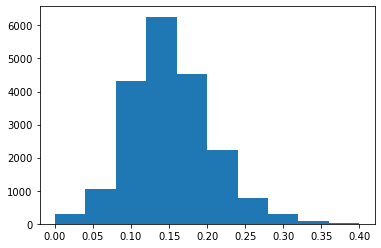

In [16]:
plt.hist(depth_dict.values())
plt.show()

In [17]:
df_liu_2019[:2]

,Unnamed: 0,total_muts,nonsyn_muts,clonal_muts,subclonal_muts,heterogeneity,total_neoantigens,CNA_prop,"gender (Male=1, Female=0)",biopsy site,...,daysBiopsyToPD1,daysBiopsyAfterIpiStart,purity,ploidy,hla_class_ii_alleles,homozygous,hla_class_ii_alleles_replace,hla_class_ii_replace_reformat,depth_ave,aa_ave
0,Patient10,96,71,48,22,0.314286,230,0.391384,0,skin,...,-12,107,0.83,1.84,"DRB1*04:01,DRB1*15:01,DQA1*01:02,DQA1*03:01,DQ...",1,"DRB1*04:01,DRB1*15:01,DQA1*01:02,DQA1*03:01,DQ...","HLA-DRB1*04:01,HLA-DRB1*15:01,HLA-DQAB*01:02_0...",0.024536,0.150551
1,Patient100,200,126,98,24,0.196721,301,0.029447,0,skin,...,-94,33,0.11,2.17,"DRB1*01:01,DRB1*15:01,DQA1*01:01,DQA1*01:02,DQ...",1,"DRB1*01:01,DRB1*15:01,DQA1*01:01,DQA1*01:02,DQ...","HLA-DRB1*01:01,HLA-DRB1*15:01,HLA-DQAB*01:01_0...",0.017504,0.114182


In [18]:
df_liu_2019.hla_class_ii_replace_reformat.tolist()[0]

'HLA-DRB1*04:01,HLA-DRB1*15:01,HLA-DQAB*01:02_03:02,HLA-DQAB*01:02_06:02,HLA-DQAB*03:01_03:02,HLA-DQAB*03:01_06:02,HLA-DPAB*01:03_04:01,HLA-DPAB*01:03_04:01,HLA-DPAB*01:03_04:01,HLA-DPAB*01:03_04:01'

In [19]:
# compute the distance for each subject based on TCR sets

# for DRB, use the set distance between the two
# for DQAB, use the average of six set distances
# for DQAB, use the average of six set distances


def ave_six(input_list, input_dict):
    
    temp_dist = 0
    
    for i in range(3):
        for j in range((i+1),4):
            temp_dist += input_dict[(input_list[i], input_list[j])]
            
    temp_result = temp_dist/6
    return temp_result




genotype_replace_list = [x.split(",") for x in df_liu_2019.hla_class_ii_replace_reformat.tolist()]

set_depth_rr = []
set_depth_qq = []
set_depth_pp = []

for genotype in genotype_replace_list:
    
    set_depth_rr += [depth_dict[(genotype[0], genotype[1])]]
    
    set_depth_qq += [ave_six(genotype[2:6], depth_dict)]   
    set_depth_pp += [ave_six(genotype[6:], depth_dict)]

set_depth_ave = [(x+y+z)/3 for x,y,z in zip(set_depth_rr, set_depth_qq, set_depth_pp)]

In [20]:
df_liu_2019["depth_set_ave"] = set_depth_ave

In [21]:
df_liu_2019.shape

(120, 53)

In [22]:
df_liu_2019.columns.tolist()

['Unnamed: 0',
 'total_muts',
 'nonsyn_muts',
 'clonal_muts',
 'subclonal_muts',
 'heterogeneity',
 'total_neoantigens',
 'CNA_prop',
 'gender (Male=1, Female=0)',
 'biopsy site',
 'monthsBiopsyPreTx',
 'BR',
 'PFS',
 'OS',
 'TimeToBR',
 'cyclesOnTherapy',
 'txOngoing',
 'Tx',
 'Mstage (IIIC=0, M1a=1, M1b=2, M1c=3)',
 'Tx_Start_ECOG',
 'Tx_Start_LDH',
 'LDH_Elevated',
 'Brain_Met',
 'Cut_SubQ_Met',
 'LN_Met',
 'Lung_Met',
 'Liver_Visc_Met',
 'Bone_Met',
 'progressed',
 'dead',
 'Primary_Type',
 'Histology',
 'IOTherapy',
 'steroidsGT10mgDaily',
 'priorMAPKTx',
 'priorCTLA4',
 'postCTLA4',
 'postMAPKTx',
 'postCombinedCTLA_PD1',
 'numPriorTherapies',
 'biopsy site_categ',
 'biopsyContext (1=Pre-Ipi; 2=On-Ipi; 3=Pre-PD1; 4=On-PD1)',
 'daysBiopsyToPD1',
 'daysBiopsyAfterIpiStart',
 'purity',
 'ploidy',
 'hla_class_ii_alleles',
 'homozygous',
 'hla_class_ii_alleles_replace',
 'hla_class_ii_replace_reformat',
 'depth_ave',
 'aa_ave',
 'depth_set_ave']

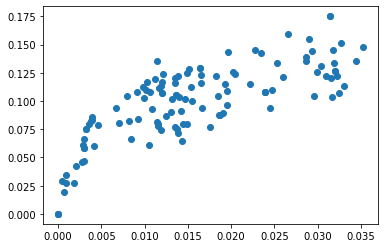

In [23]:
plt.scatter(df_liu_2019.depth_ave, df_liu_2019.depth_set_ave)
plt.show()

In [24]:
set([x for y in genotype_replace_list for x in y]) == set(df_hla.hla)

True

In [25]:
# compute hla breadth metric for each subject

# first, get list of sets with unioned set of TCRs as the set

depth_subject_list = []

for geno in genotype_replace_list:
    
    ten_depth_sets = [depth_hla_dict[geno[0]], depth_hla_dict[geno[1]], 
                      depth_hla_dict[geno[2]], depth_hla_dict[geno[3]],
                      depth_hla_dict[geno[4]], depth_hla_dict[geno[5]], 
                      depth_hla_dict[geno[6]], depth_hla_dict[geno[7]],
                      depth_hla_dict[geno[8]], depth_hla_dict[geno[9]]]
                    
    cur_depth_union = set().union(*ten_depth_sets)
                    
    depth_subject_list += [cur_depth_union]
    
    
# second, get hla breadth for each subject

depth_breadth = [len(x) for x in depth_subject_list]
   
df_liu_2019["depth_breadth"] = depth_breadth

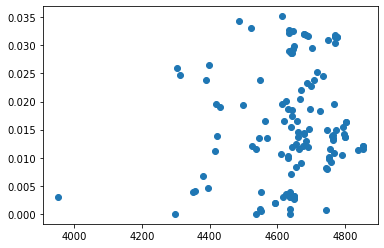

In [26]:
plt.scatter(df_liu_2019.depth_breadth, df_liu_2019.depth_ave)
plt.show()

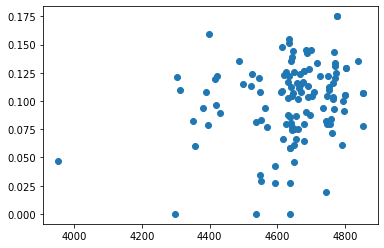

In [27]:
plt.scatter(df_liu_2019.depth_breadth, df_liu_2019.depth_set_ave)
plt.show()

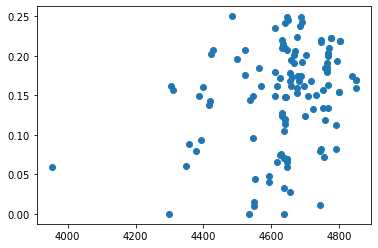

In [28]:
plt.scatter(df_liu_2019.depth_breadth, df_liu_2019.aa_ave)
plt.show()

In [29]:
# save the extended df_liu_2019 file out
df_liu_2019.to_csv("../results/st24_liu_2019_hla_ii_depth_aa_set_breadth.csv", 
                   index = False)